In [1]:
import os
os.chdir(f"../../..")
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from time import time
import h5py

In [2]:
image_depth=8 # or 16 bit per pixel
saturation=1
image_shortest_side=540
resolution_side_nx=image_shortest_side # generated images will be resolution_side x resolution_side

experiment_name="Basler_like_R0_300x_w0_300x_Z_50x_64bit"
output_directory=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/{experiment_name}/"
image_directory=f"{output_directory}/SIMULATIONS/" #nx_{image_shortest_side}_depth_{image_depth}_sat_{saturation}
phase_vigilant = json.load(open(f"{output_directory}/STRUCTURE_Grid.json"))


X=int(resolution_side_nx*1.15/2) # 605
im_type=np.uint16 if image_depth==16 else np.uint8
max_intensity=65535 if image_depth==16 else 255

FileNotFoundError: [Errno 2] No such file or directory: '/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit//STRUCTURE_Grid.json'

In [3]:
# GENERAL ROUTINES #################################
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    return centered_image
    '''
    else:
        # We compute the center of gravity of the cropped images, if everything was made allright
        # they should get just centered in the central pixels number X+1 (index X)
        g_centered = compute_intensity_gravity_center(centered_image)

        # We now compute a floating translation of the image so that the gravicenter is exactly
        # centered at pixel (607.5, 607.5) (exact center of the image in pixel coordinates staring
        # form (0,0) and having size (607*2+1)x2), instead of being centered at the beginning of
        # around pixel (607,607) as is now
        translate_vectors = X+0.5-g_centered #[ 2(h,w)]
        T = np.float64([[1,0, translate_vectors[1]], [0,1, translate_vectors[0]]])
        return cv2.warpAffine( centered_image, T, (X*2+1, X*2+1),
                    flags=interpolation_flag) # interpolation method
    '''

# lzf

In [37]:
phiCRs = np.linspace(0,2*np.pi-0.01, 10)
t00=time()
h5f = h5py.File(f"{image_directory}/Dataset.h5",'r')
phis = h5f['phis'][:]

for ID in h5f.keys(): # phase_vigilant['IDs']: 
    for phiCR in phiCRs:

        D_mats = h5f[ID][:]
        
        image = D_mats[0]+D_mats[1]*np.cos(phiCR-phis)
        # convert to selected uint format
        image = (max_intensity*(image/image.max())).astype(im_type)

        # get iX (saturated) image
        #image = np.where( image<=(max_intensity*saturation), image, max_intensity*saturation) # saturation application if necessary
        image = compute_raw_to_centered_iX(image, X)

        # save the image
        rel_path=f"{image_directory}/{ID}_phiCR_{phiCR}.png"
        cv2.imwrite( rel_path, image)

tff=time()
print(f"Total elapsed time {tff-t00}s -> per image: {(tff-t00)/(len(phase_vigilant['IDs'])*len(phiCRs))} \nNote saving images will not be required, just that applying noise will\nAlso, in reality one can apply iX and normalization to the whole batch at once in the GPU")
print(f"hf5 size {os.path.getsize(image_directory+'/Dataset.h5')}-> per image {os.path.getsize(image_directory+'/Dataset.h5')/(len(phase_vigilant['IDs']))}")   

        
h5f.close()

Total elapsed time 0.59206223487854s -> per image: 0.00740077793598175 
Note saving images will not be required, just that applying noise will
Also, in reality one can apply iX and normalization to the whole batch at once in the GPU
hf5 size 14109876-> per image 1763734.5


# gzip

In [7]:
phiCRs = np.linspace(0,2*np.pi-0.01, 10)
t00=time()
h5f = h5py.File(f"{image_directory}/Dataset.h5",'r')
phis = h5f['phis'][:]

for ID in phase_vigilant['IDs']: #h5f.keys():
    for phiCR in phiCRs:

        D_mats = h5f[ID][:]
        
        image = D_mats[0]+D_mats[1]*np.cos(phiCR-phis)
        # convert to selected uint format
        image = (max_intensity*(image/image.max())).astype(im_type)

        # get iX (saturated) image
        #image = np.where( image<=(max_intensity*saturation), image, max_intensity*saturation) # saturation application if necessary
        image = compute_raw_to_centered_iX(image, X)

        # save the image
        rel_path=f"{image_directory}/{ID}.png"
        cv2.imwrite( rel_path, image)

tff=time()
print(f"Total elapsed time {tff-t00}s -> per image: {(tff-t00)/(len(phase_vigilant['IDs']))} \nNote saving images will not be required, just that applying noise will\nAlso, in reality one can apply iX and normalization to the whole batch at once in the GPU")
print(f"hf5 size {os.path.getsize(image_directory+'/Dataset.h5')}-> per image {os.path.getsize(image_directory+'/Dataset.h5')/(len(phase_vigilant['IDs']))}")   

        
h5f.close()

Total elapsed time 0.981055736541748s -> per image: 0.1226319670677185 
Note saving images will not be required, just that applying noise will
Also, in reality one can apply iX and normalization to the whole batch at once in the GPU
hf5 size 13122984-> per image 1640373.0


# Dataset Class

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
#device="cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

'''
La idea es que cada 5 epochs, se cambie el dataset efectivo, que sera un subset de los R0,w0,Z posibles
multiplicado por el batch size (phiCR posibles). En cada batch, las imagenes enviadas seran todas
de un mismo D matrix (R0,w0,Z) con diferentes angulos elegidos aleatoriamente con una uniforme
'''
class R0_w0_Z_Sampler(Sampler):
    def __init__(self, R0_weights, w0_weights, Z_weights, num_batches_per_epoch):
        self.num_batches = num_batches_per_epoch
        self.R0_weights = R0_weights
        self.w0_weights = w0_weights
        self.Z_weights = Z_weights

    def __iter__(self):
        return iter(torch.stack((
            torch.multinomial(self.R0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.w0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.Z_weights, self.num_batches, replacement=True)),
            dim=1).tolist())

    def __len__(self):
        return self.num_samples


class CR_Dataset(Dataset):
    def __init__(self, D_matrix_file_path, ID_file_path, device, X=605, generate_images_w_depth=8, random_seed=666, 
                batch_size=10, num_batches_per_epoch=100, apply_noise=True,
                all_stregths_random_per_epoch=False,
                max_poisson_strength=0.5, max_blob_strength=0.5, max_angular_modulation_strength=0.5,
                poisson_strength=0.3, blob_strength=0.1, angular_modulation_strength=0.25,
                min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                max_blobs=1, min_blob_sigma=100, max_blob_sigma=130
                ):
        # If all_strengths_random_per_ecpoh, then arguments about the maximum will be valid while not the strength arguments
        # If false, then the arguments about the particular stregths will be the global stregths
        np.random.seed(random_seed) 
        torch.manual_seed(random_seed)
        self.D_matrix_file_path=D_matrix_file_path
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(ID_file_path)))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch
        self.epoch_size = batch_size*num_batches_per_epoch
        self.device = device
        self.im_type = torch.uint16 if generate_images_w_depth==16 else torch.uint8
        self.max_intensity = 65535 if generate_images_w_depth==16 else 254
        self.X=X
        self.apply_noise=apply_noise
        self.poisson_strength=poisson_strength
        self.blob_strength=blob_strength
        self.angular_modulation_strength=angular_modulation_strength
        self.min_modulation_frec=min_modulation_frec
        self.max_modulation_frec=max_modulation_frec
        self.max_blobs=max_blobs
        self.min_blob_sigma=min_blob_sigma
        self.max_blob_sigma=max_blob_sigma
        self.all_stregths_random_per_epoch=all_stregths_random_per_epoch
        self.max_poisson_strength=max_poisson_strength
        self.max_blob_strength=max_blob_strength
        self.max_angular_modulation_strength=max_angular_modulation_strength
        
    #def update_dataset o set_epoch_number y que aqui se genere directamente el dataset entero para las epochs que vienen
    # lo que permitiria es que cada X epochs, se ahorrase el tener que re-generar todas las imagenes
    # Pero claro, la pregunta es, la RAM aguantaria?
    # Si haces con update_dataset, entonces no haria falta hacer un sampler custom, con el normal ya bastaria
    
    # Bueno, por ahora, vamos a hacer que en cada minibatch, se haga todo el puroceso. La cosa es que asi se 
    # puede aprovechar el multiprocessing innato, si no habria que hacer el multiprocessing dentroe del update_dataset
    # o simplemente prescindir de hacerlo supongo.
    
    def __del__(self):
        if hasattr(self, 'h5f_D_matrices'):
            self.h5f_D_matrices.close()
        
    def __len__(self):
        return self.epoch_size
    
    def open_hdf5(self):
        self.h5f_D_matrices = h5py.File( self.D_matrix_file_path, 'r')
        #self.dataset = self.img_hdf5['dataset'] # if you want dataset.
        

    def compute_intensity_gravity_centers(self, images):
        """
            Expects input image to be an array of dimensions [N_imgs, h, w].
            It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to array indices

        """
        # image wise total intensity and marginalized inensities for weighted sum
        intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
        intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
        total_intensity = intensity_in_h.sum(dim=1) # [N_images]

        # Compute mass center for intensity
        # [N_images, 2] (h_center,w_center)
        return torch.nan_to_num( torch.stack(
            (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                        dtype=torch.float32, device=self.device))/total_intensity,
             torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                        dtype=torch.float32, device=self.device))/total_intensity),
            dim=1
            ), nan=0.0, posinf=None, neginf=None)

    def compute_raw_to_centered_iX(self, images):

        g_raw = self.compute_intensity_gravity_centers(images) # [ N_images, 2]

        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_images = torch.zeros( ( images.shape[0], 2*self.X+1, 2*self.X+1),  dtype = images.dtype, 
                                      device=self.device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-self.X
        unclipped_upper = g_index_raw+self.X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        for im in range(g_raw.shape[0]):
            centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                        padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                      images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                          lower_bound[ im, 1]:upper_bound[ im, 1]]

        return centered_images
    
    def apply_random_camera_noises(self, images):
        # Poisson noise
        # the images are expected to already be normalized and in the integer range of the camera
        return torch.clamp((1-self.poisson_strength)*images+self.poisson_strength*torch.poisson(images), max=self.max_intensity) 
                                    # rates are the expected intensities of the imaging time

    def _gaussian_2D_pdfs(self, x_ys, mus, sigmas, strengths):
        '''
        x_ys : [batch_size, blob_num, 2 (h,w), 2X+1, 2X+1]
        mus : [batch_size, blob_num, 2 (h,w), 1, 1]
        sigmas : [batch_size, blob_num, 2(h,w), 1, 1]
        strengths : [batch_size, blob_num, 1, 1]
        ------
        out : [batch_size, 2X+1, 2X+1]
        '''
        gaussians = torch.sum((strengths/(2*np.pi)/sigmas[:,:,0]/sigmas[:,:,1])*torch.exp(
                -(x_ys[:,:,0,:,:]-mus[:,:,0])**2/(2*sigmas[:,:,0]**2))*torch.exp(
                -(x_ys[:,:,1,:,:]-mus[:,:,1])**2/(2*sigmas[:,:,1]**2)), dim=1) # since strength is normalized, the whole mixture is normalized as well
        return gaussians/gaussians.amax(dim=(1,2)).unsqueeze(1).unsqueeze(2)

    def apply_random_pre_camera_noises(self, images):
        # note that the input images are expected to still be centered in the gravicenter and have no normalization

        # Gaussian Blobs - subtract gaussian blobs of different depths to the intensity pattern
        # First randomly sample the centers of the blobs and their standard deviations for each image
        # we will sample the means with probabilities proportional to the CR ring intensity pattern
        blob_num = np.random.randint(0, self.max_blobs+1, size=1)[0]
        if blob_num!=0:
            mu_s = torch.stack(
                (torch.multinomial(images.sum(dim=2),
                        num_samples=blob_num, 
                        replacement=False), 
                 torch.multinomial(images.sum(dim=1),
                        num_samples=blob_num, 
                        replacement=False) ),
                 dim=2
                ).to(self.device) #[batch_size, blob_num, 2(h,w)] mu-s are in pixel units and coordinates

            sigma_s = torch.from_numpy(np.random.randint(self.min_blob_sigma, self.max_blob_sigma, 
                        size=(images.shape[0], blob_num, 2))).to(self.device) #[batch_size, blob_num, 2(h,w)]
            strengths = torch.rand(size=(images.shape[0], blob_num)).to(self.device) #[batch_size, blob_num]
            strengths = strengths/strengths.sum(dim=1).unsqueeze(1) # normalized strengths between blobs

            w = torch.arange(images.shape[1]).repeat((images.shape[1],1)).to(self.device)
            h = w.transpose(0,1).to(self.device)
            h_w = torch.stack((h,w), dim=0).to(self.device)
            images = images*(1-self.blob_strength*self._gaussian_2D_pdfs( h_w.view((1,1)+h_w.shape), 
                mu_s.view(mu_s.shape+(1,1)), sigma_s.view(sigma_s.shape+(1,1)), strengths.view(strengths.shape+(1,1)) )
                     )           #[batch_size, 2X+1, 2X+1]        
        # Poisson noise - makes the intesity be a poissonian generated value instead of the expected values
        #images = (1-poisson_strength)*images+poisson_strength*torch.poisson(images) # rates are the expected intensities of the imaging time
        # but must be an integer matrix!

        # Angular Modulation - apply a pseudo-random continous wave modulation to the ring angularly
        random_frecs = (self.min_modulation_frec + (self.max_modulation_frec-self.min_modulation_frec)*torch.rand(
                                size=(3,images.shape[0], 1,1))).to(self.device)
        strengths = torch.rand(size=(3, images.shape[0], 1,1)).to(self.device) #[3, batch_size, 1,1]
        strengths = strengths/strengths.sum(dim=0) # normalized strengths between sin and coss
        images = images*(
            1-self.angular_modulation_strength*(
                strengths[0]*torch.cos(random_frecs[0]*self.phis)+
                strengths[1]*torch.sin(random_frecs[1]*self.phis)+
                strengths[2]*torch.cos(random_frecs[2]*self.phis)
            )**2) #[batch_size, 2X+1, 2X+1]

        # Angular-Radial Modulation # sería coger phis y coger radios y con eso hacer uan funcion de ambas, de forma
        # que por ejemplo afecte de manera diferente al mismo angulo en cada ring el pre-pogendorf y el otro

        # Modos superiores
        # esto ya es un jaleo xD
        return images

    
    
    def __getitem__(self, R0_w0_Z_idxs):
        # In order to allow multiprocessing data loading, each worker needs to initialize 
        # the h5f loader, which must be done in the first iteration of getitem and not in the init
        # of the parent process
        if not hasattr(self, 'h5f_D_matrices'):
            self.open_hdf5()
            self.phis = torch.from_numpy(self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(self.device) #[1,Nx,Ny]

        try:
            D_mats = torch.from_numpy(self.h5f_D_matrices[
                f"R0_{self.R0s[R0_w0_Z_idxs[0]]}_w0_{self.w0s[R0_w0_Z_idxs[1]]}_Z_{self.Zs[R0_w0_Z_idxs[2]]}"][:]
                                 ).unsqueeze(1).to(self.device) #[2, 1, Nx, Ny]
        except:
            D_mats = torch.from_numpy(self.h5f_D_matrices[
                f"R0_100.28985507246377_w0_10.318840579710145_Z_0.0"][:]
                                 ).unsqueeze(1).to(self.device) #[2, 1, Nx,Ny]
            
        
        phiCRs = torch.FloatTensor(self.batch_size, 1, 1).uniform_(0, 2*np.pi).to(self.device) #[batch_size, 1, 1]
        neat_images = D_mats[0]+D_mats[1]*torch.cos(phiCRs-self.phis) #[batch_size, Nx,Ny]
        
        if self.apply_noise:
            if self.all_stregths_random_per_epoch:
                self.poisson_strength = self.max_poisson_strength*np.random.rand()
                self.angular_modulation_strength = self.max_angular_modulation_strength*np.random.rand()
                self.blob_strength = self.max_blob_strength*np.random.rand()
            
            # Apply precamera noise to images (while still floats)
            spoiled_images = self.apply_random_pre_camera_noises(neat_images)
        
        # convert images to selected uint format
        spoiled_images = (self.max_intensity*(spoiled_images/spoiled_images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1)))
        
        if self.apply_noise:
            # Apply camera noises (now that normalized and integers)
            spoiled_images = self.apply_random_camera_noises(spoiled_images)
        
        spoiled_images = spoiled_images.type(self.im_type)
    
        neat_images = (self.max_intensity*(neat_images/neat_images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1))).type(self.im_type)
        
        
        # get iX images
        neat_images = self.compute_raw_to_centered_iX(neat_images) #[batch_size, 2X+1, 2X+1]
        spoiled_images = self.compute_raw_to_centered_iX(spoiled_images) #[batch_size, 2X+1, 2X+1]
        labels = torch.Tensor([[float(self.R0s[R0_w0_Z_idxs[0]]), float(self.w0s[R0_w0_Z_idxs[1]]), 
                               float(self.Zs[R0_w0_Z_idxs[2]])]]).to(self.device) #[1,4]
        labels = torch.hstack( ( labels.expand(self.batch_size, 3), phiCRs.squeeze(2) ) ) #[4, batch_size]
        del D_mats, phiCRs
        torch.cuda.empty_cache()
        return spoiled_images, labels, neat_images #[ batch_size, 2X+1, 2X+1] and [batch_size, 4]
        # The whole batch is already in the GPU, since to process it we wanted it to be there
    

cuda:0


In [4]:
def gaussian_pdf(x, mu, sigma, normalized_output=True):
    p_s = (1/np.sqrt(2*np.pi)/sigma)*torch.exp(-(x-mu)**2/(2*sigma**2))
    return p_s/p_s.sum() if normalized_output else p_s

phase_vigilant = pd.DataFrame.from_dict(json.load(open("/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/STRUCTURE_Grid_R0_70_w0_70_Z_4.json")))
R0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['R0s'].drop_duplicates(), dtype=np.float64)),
                          mu=158, sigma=35)
w0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['w0s'].drop_duplicates(), dtype=np.float64)),
                          mu=25, sigma=10)
Z_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['Zs'].drop_duplicates(), dtype=np.float64)),
                          mu=0, sigma=0.5)
#print(R0_weights,  phase_vigilant['R0s'].drop_duplicates())
#print(w0_weights, phase_vigilant['w0s'].drop_duplicates())
#print(Z_weights, phase_vigilant['Zs'].drop_duplicates())

In [207]:
num_batches=3
sampler = R0_w0_Z_Sampler( R0_weights, w0_weights, Z_weights, num_batches)
dataset = CR_Dataset(D_matrix_file_path="/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Dataset_R0_70_w0_70_Z_4.h5",
            ID_file_path ="/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json", 
            device = device,
            X=302, generate_images_w_depth=8, random_seed=666, 
            batch_size=5, num_batches_per_epoch=100, apply_noise=True,
                poisson_strength=0.3, blob_strength=0.1, angular_modulation_strength=0.25,
               min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                max_blobs=1, min_blob_sigma=100, max_blob_sigma=130)

In [11]:
num_batches=3
sampler = R0_w0_Z_Sampler( R0_weights, w0_weights, Z_weights, num_batches)
dataset = CR_Dataset(D_matrix_file_path="/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/Dataset_R0_70_w0_70_Z_4.h5",
            ID_file_path ="/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/STRUCTURE_Grid_R0_70_w0_70_Z_4.json", 
            device = device,
            X=302, generate_images_w_depth=8, random_seed=666, 
            batch_size=5, num_batches_per_epoch=100,
                    apply_noise=True,
                poisson_strength=0.3, blob_strength=0.25, angular_modulation_strength=0.25,
               min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                max_blobs=3, min_blob_sigma=100, max_blob_sigma=130)


In [5]:
import cv2
times=[]
for i in sampler: # outputea por cada batch un index
    t=time()
    ims = dataset[i]
    break
    ims, lab, neat_ims=dataset[i]
    times.append(time()-t)
    #print(ims.shape, lab.shape, ims.is_cuda, lab.is_cuda, ims.dtype, lab.dtype)
    for j in range(ims.shape[0]):
        #print(lab[j])
        cv2.imwrite(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/{str(lab[j])}.png", np.array(ims[j].to('cpu')))
        #print(dataset.compute_intensity_gravity_centers(ims))
print(f"Batch processing times -retrieval+image generation- where: {times}")

Batch processing times -retrieval+image generation- where: []


In [309]:
def apply_random_float_noises(images, phis, poisson_strength=0.3, blob_strength=0.1, angular_modulation_strength=0.25,
                       min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                        max_blobs=1, min_blob_sigma=100, max_blob_sigma=130):
    # note that the input images are expected to still be centered in the gravicenter and have no normalization
    assert(0<=poisson_strength<=1)
    
    # Gaussian Blobs - subtract gaussian blobs of different depths to the intensity pattern
    # First randomly sample the centers of the blobs and their standard deviations for each image
    # we will sample the means with probabilities proportional to the CR ring intensity pattern
    blob_num = np.random.randint(0, max_blobs+1, size=1)[0]
    if blob_num==-1:
        mu_s = torch.stack(
            (torch.multinomial(images.sum(dim=2),
                    num_samples=blob_num, 
                    replacement=False), 
             torch.multinomial(images.sum(dim=1),
                    num_samples=blob_num, 
                    replacement=False) ),
             dim=2
            ).to(device) #[batch_size, blob_num, 2(h,w)] mu-s are in pixel units and coordinates

        sigma_s = torch.from_numpy(np.random.randint(min_blob_sigma, max_blob_sigma, size=(images.shape[0], blob_num, 2))).to(device) #[batch_size, blob_num, 2(h,w)]
        strengths = torch.rand(size=(images.shape[0], blob_num)).to(device) #[batch_size, blob_num]
        strengths = strengths/strengths.sum(dim=1).unsqueeze(1) # normalized strengths between blobs
        def gaussian_2D_pdfs(x_ys, mus, sigmas, strengths):
            '''
            x_ys : [batch_size, blob_num, 2 (h,w), 2X+1, 2X+1]
            mus : [batch_size, blob_num, 2 (h,w), 1, 1]
            sigmas : [batch_size, blob_num, 2(h,w), 1, 1]
            strengths : [batch_size, blob_num, 1, 1]
            ------
            out : [batch_size, 2X+1, 2X+1]
            '''
            gaussians = torch.sum((strengths/(2*np.pi)/sigmas[:,:,0]/sigmas[:,:,1])*torch.exp(
                    -(x_ys[:,:,0,:,:]-mus[:,:,0])**2/(2*sigmas[:,:,0]**2))*torch.exp(
                    -(x_ys[:,:,1,:,:]-mus[:,:,1])**2/(2*sigmas[:,:,1]**2)), dim=1) # since strength is normalized, the whole mixture is normalized as well
            return gaussians/gaussians.amax(dim=(1,2)).unsqueeze(1).unsqueeze(2)

        w = torch.arange(images.shape[1]).repeat((images.shape[1],1)).to(device)
        h = w.transpose(0,1).to(device)
        h_w = torch.stack((h,w), dim=0).to(device)
        images = images*(1-blob_strength*gaussian_2D_pdfs( h_w.view((1,1)+h_w.shape), 
            mu_s.view(mu_s.shape+(1,1)), sigma_s.view(sigma_s.shape+(1,1)), strengths.view(strengths.shape+(1,1)) )
                 )           #[batch_size, 2X+1, 2X+1]        
    # Poisson noise - makes the intesity be a poissonian generated value instead of the expected values
    #images = (1-poisson_strength)*images+poisson_strength*torch.poisson(images) # rates are the expected intensities of the imaging time
    # but must be an integer matrix!
    
    # Angular Modulation - apply a pseudo-random continous wave modulation to the ring angularly
    random_frecs = (min_modulation_frec + (max_modulation_frec-min_modulation_frec)*torch.rand(size=(3,images.shape[0], 1,1))).to(device)
    strengths = torch.rand(size=(3, images.shape[0], 1,1)).to(device) #[3, batch_size, 1,1]
    strengths = strengths/strengths.sum(dim=0) # normalized strengths between sin and coss
    images = images*(
        1-angular_modulation_strength*(
            strengths[0]*torch.cos(random_frecs[0]*phis)+
            strengths[1]*torch.sin(random_frecs[1]*phis)+
            strengths[2]*torch.cos(random_frecs[2]*phis)
        )**2) #[batch_size, 2X+1, 2X+1]
    
    # Angular-Radial Modulation # sería coger phis y coger radios y con eso hacer uan funcion de ambas, de forma
    # que por ejemplo afecte de manera diferente al mismo angulo en cada ring el pre-pogendorf y el otro
    
    # Modos superiores
    # esto ya es un jaleo xD
        
    return images
    
    

In [310]:
import cv2
times=[]
for i in sampler: # outputea por cada batch un index
    t=time()
    ims,lab,  neat_ims = dataset[i]
    break
    ims, lab=dataset[i]
    times.append(time()-t)
    #print(ims.shape, lab.shape, ims.is_cuda, lab.is_cuda, ims.dtype, lab.dtype)
    for j in range(ims.shape[0]):
        #print(lab[j])
        cv2.imwrite(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/{str(lab[j])}.png", np.array(ims[j].to('cpu')))
        #print(dataset.compute_intensity_gravity_centers(ims))
print(f"Batch processing times -retrieval+image generation- where: {times}")

Batch processing times -retrieval+image generation- where: []


In [5]:
'''
phis = dataset.phis
noisy_ims = apply_random_noises(ims, phis, poisson_strength=0.9, blob_strength=0.35, 
                                angular_modulation_strength=0.2    )
noisy_imsy = (dataset.max_intensity*(noisy_ims/noisy_ims.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1))).type(dataset.im_type)
imsy = (dataset.max_intensity*(ims/ims.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1))).type(dataset.im_type)
'''
#noisy_nims = np.asarray(noisy_imsy.to('cpu')) 
nims = np.asarray(ims.to('cpu'))
#nphis = np.asarray(phis.to('cpu'))

In [12]:
num_batches=3
sampler = R0_w0_Z_Sampler( R0_weights, w0_weights, Z_weights, num_batches)
dataset = CR_Dataset(D_matrix_file_path="/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/Dataset_R0_70_w0_70_Z_4.h5",
            ID_file_path ="/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/STRUCTURE_Grid_R0_70_w0_70_Z_4.json", 
            device = device,
            X=302, generate_images_w_depth=8, random_seed=666, 
            batch_size=5, num_batches_per_epoch=100,
                    apply_noise=True, all_stregths_random_per_epoch=True,
                     max_poisson_strength=0.5, max_blob_strength=0.5, max_angular_modulation_strength=0.5,
                poisson_strength=0.4, blob_strength=0.2, angular_modulation_strength=0.2,
               min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                max_blobs=2, min_blob_sigma=100, max_blob_sigma=130)
times=[]
for i in sampler: # outputea por cada batch un index
    t=time()
    ims, labs, neat_ims = dataset[i]
    break
    
nims = np.asarray(ims.to('cpu'))
nneat_ims =np.asarray(neat_ims.to('cpu'))

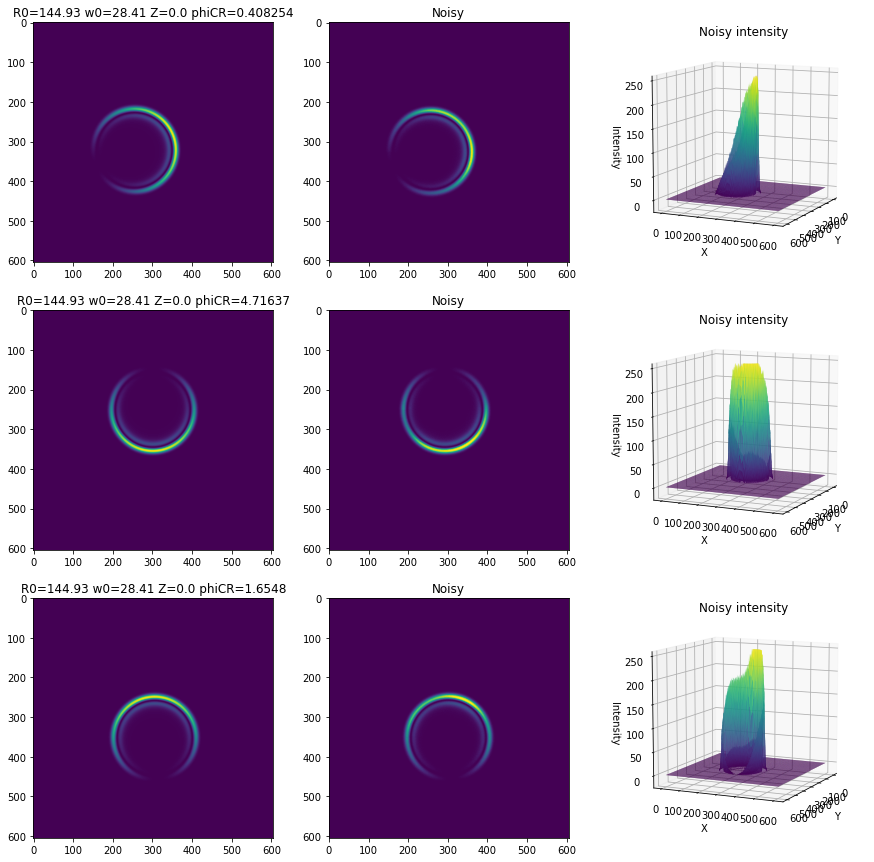

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

ims_to_show=min(3, nims.shape[0])
fig, axes = plt.subplots(ims_to_show,3,figsize=(15,15))
for i in range(ims_to_show):
    axes[i, 0].imshow(nneat_ims[i])
    axes[i,0].set_title(f"R0={labs[i][0].item():.5} w0={labs[i][1].item():.4} Z={labs[i][2].item():.2} phiCR={labs[i][3].item():.6}")
    axes[i, 1].imshow(nims[i])
    axes[i,1].set_title(f"Noisy")
    axes[i, 2].set_visible(False)
    ax = fig.add_subplot(int(f"{ims_to_show}3{i*3+3}"), projection='3d')
    X,Y = np.meshgrid(np.arange(nims.shape[1]),np.arange(nims.shape[2]))
    theta=25
    phi=30
    plot3d_resolution = 0.7
    ax.plot_surface(X, Y, nims[i].T, rcount=int(nims.shape[1]*plot3d_resolution), ccount=int(nims.shape[2]*plot3d_resolution), cmap='viridis') # rstride=1, cstride=1, linewidth=0
    #cset = ax.contourf(X, Y, im, 2, zdir='z', offset=-20, cmap='viridis', alpha=0.5)
    #cset = ax.contourf(X, Y, im, 1, zdir='x', offset=-8, cmap='viridis')
    #cset = ax.contourf(X, Y, im, 1, zdir='y', offset=0, cmap='viridis')
    ax.set_xlabel('Y')
    #ax.set_xlim(-8, 8)
    ax.set_ylabel('X')
    #ax.set_ylim(-10, 8)
    ax.set_zlabel('Intensity')
    ax.set_zlim(-0.078*np.max(nims[i]), np.max(nims[i]))
    ax.set_title("Noisy intensity")
    ax.view_init(10, theta)
plt.show()

In [94]:
strengths = torch.rand(size=(3, ims.shape[0], 1,1)) #[3, batch_size, 1,1]

strengths=strengths/strengths.sum(dim=0)
print(strengths.shape, strengths[:,0].sum())

torch.Size([3, 5, 1, 1]) tensor(1.)


In [ ]:
loader =DataLoader(
    dataset=dataset, batch_size=1, sampler=sampler, num_workers=5, # each index yielded by the sampler is intended to be a full mini-batch already
           # we can take advantage of the workers only if meta-batches are more than 1, so we can do it, just reducing the sub-batch
           shuffle=False, 
           batch_sampler=None, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None,
           multiprocessing_context=None, generator=None, *, prefetch_factor=2,
           persistent_workers=False)

In [ ]:
for datas, targets in loader:
    print(datas.shape, targets.shape)
    print(datas.is_cuda, targets.is_cuda)
# checkea tb que las matrices intermedias que mando al device se vayan olvidando cuando ya no se necesiten
# Quizas hay que hacerlo explicitamente!

In [209]:
l=torch.Tensor([[9.2], [10.2], [14.3]])
a=torch.torch.FloatTensor(1,1, 10).uniform_(0, 2*np.pi)
print(a.squeeze(0).shape)
torch.vstack((l.expand(3, 10), a.squeeze(0))).shape

torch.Size([1, 10])


torch.Size([4, 10])

In [190]:
g_raw=torch.stack((torch.matmul(torch.tensor([[21, 3,3,5],[2,3,3,6],[2,3,3,6]]).transpose(0,1).transpose(0,1), torch.arange(4))/1000,
            torch.matmul(torch.tensor([[21, 3,3,5],[2,3,3,6],[2,3,3,6]]).transpose(0,1).transpose(0,1), torch.arange(4))/1000),
                 )
print(g_raw)
print(g_raw.dtype)

tensor([[0.0240, 0.0270, 0.0270],
        [0.0240, 0.0270, 0.0270]])
torch.float32


In [186]:
g_raw=torch.stack((torch.matmul(torch.tensor([[2.1, 3,3,5],[2,3,3,6],[2,3,3,6]]).transpose(0,1).transpose(0,1), torch.arange(4, dtype=torch.float32)),
            torch.matmul(torch.tensor([[2.1, 3,3,5],[2,3,3,6],[2,3,3,6]]).transpose(0,1).transpose(0,1), torch.arange(4, dtype=torch.float32))),
                 )
print(g_raw.dtype)
torch.round(g_raw).int()

torch.float32


tensor([[24, 27, 27],
        [24, 27, 27]], dtype=torch.int32)

In [150]:
Ds=torch.from_numpy(D_mats).unsqueeze(2)
phik=torch.from_numpy(phis).unsqueeze(2)
phiCRs=torch.FloatTensor(1,1, 3).uniform_(0, 2*np.pi)
images=Ds[0]+Ds[1]*torch.cos(phiCRs-phik)

images = (255*(images/images.amax(dim=(0,1), keepdim=True)[0].unsqueeze(0))).type(torch.uint8)
images = compute_raw_to_centered_iX(images, X)


tensor([[[ 93, 255,   5],
         [ 93, 254,   5],
         [ 93, 254,   4],
         ...,
         [  1,  76,  49],
         [  1,  76,  49],
         [  1,  76,  49]],

        [[ 93, 254,   5],
         [ 93, 254,   5],
         [ 93, 254,   5],
         ...,
         [  1,  76,  49],
         [  1,  76,  49],
         [  1,  75,  49]],

        [[ 94, 254,   5],
         [ 93, 254,   5],
         [ 93, 254,   5],
         ...,
         [  1,  76,  49],
         [  1,  76,  49],
         [  1,  75,  49]],

        ...,

        [[254,  56, 236],
         [254,  55, 236],
         [254,  55, 236],
         ...,
         [ 55,   9, 126],
         [ 55,   9, 126],
         [ 55,   9, 125]],

        [[254,  55, 236],
         [254,  55, 236],
         [254,  55, 236],
         ...,
         [ 55,   9, 126],
         [ 55,   9, 126],
         [ 55,   9, 126]],

        [[255,  55, 236],
         [254,  55, 236],
         [254,  55, 237],
         ...,
         [ 55,   9, 126],
        

In [128]:
(phiCRs-phik.unsqueeze(2)).shape

torch.Size([540, 540, 3])

In [90]:
for i in iter(torch.stack((torch.multinomial(torch.Tensor([0.3,0.5,0.2]), 5, replacement=True),torch.multinomial(torch.Tensor([0.3,0.5,0.2]), 5, replacement=True)),dim=1).tolist()):
    print(i)

[1, 0]
[2, 2]
[0, 0]
[0, 0]
[1, 1]


In [94]:
pd.DataFrame.from_dict(phase_vigilant)['R0s'].drop_duplicates()

0     70.0
2    178.0
Name: R0s, dtype: float64

In [109]:
list(a['R0s'].drop_duplicates())

[70.0, 178.0]

In [105]:
b=70.020202020345678987

In [108]:
print(f"pito {str(b)}")

pito 70.02020202034568


In [96]:
a = pd.DataFrame.from_dict(phase_vigilant)